# Blood Fractionation Method Analysis

First, we configure several variables we are using during this demo: project id, S3 profile and VM path to save data files from the S3 bucket: 

In [64]:
from cdispyutils.hmac4 import get_auth
import json, re
import requests
project = ''
profile = ''
path    = 'files/'

### Get Authorization using your keys from the BPA API: data.bloodpac.org/identity
These keys must be loaded in your VM's .secrets file. In the case of an access error, you may need a new keypair.

In [65]:
with open('/home/ubuntu/.secrets','r') as f:
    secrets = json.load(f)
auth = get_auth(secrets['access_key'], secrets['secret_key'], 'submission')


### Querying data from graphQL

** Find how many samples in commons have linked quantification assays:|**

In [66]:
# Setting 'gql' to the BloodPAC API graphQL url:
api='http://kubenode.internal.io:30006/v0/submission/bpa/'
gql = 'http://kubenode.internal.io:30006/v0/submission/graphql/'
data = {'query': """ {
            _sample_count(with_path_to:{type:"quantification_assay"})
        } """};

resp = requests.post(gql,auth=auth,json=data)
scount = re.search(".*_sample_count\": (\d+)",str(resp.text)).group(1)
print resp.text
scount


{
  "data": {
    "_sample_count": 392
  }
}


'392'

** Another way to do the same thing and get the samples' submitter_id and fractionation_method: **

In [67]:
 data = {'query': """ {
            sample(first:0,with_path_to:{type:"quantification_assay"}){
                submitter_id
                blood_fractionation_method
            }
        } """};

resp = requests.post(gql,auth=auth,json=data)
samps = re.findall(".*submitter_id\": \"(.+)\"",str(resp.text))
methods = re.findall('.*blood_fractionation_method\": \"(.+)\"',str(resp.text))
z = zip(samps,methods)
z = set(z)
len(z)

392

In [68]:
z # List the Sample IDs and their blood fractionation method

{('07505', 'USC_HD-SCA_Protocol'),
 ('07546', 'USC_HD-SCA_Protocol'),
 ('07822', 'USC_HD-SCA_Protocol'),
 ('07825', 'USC_HD-SCA_Protocol'),
 ('07829', 'USC_HD-SCA_Protocol'),
 ('07830', 'USC_HD-SCA_Protocol'),
 ('07849', 'USC_HD-SCA_Protocol'),
 ('07859', 'USC_HD-SCA_Protocol'),
 ('07910', 'USC_HD-SCA_Protocol'),
 ('07915', 'USC_HD-SCA_Protocol'),
 ('07933', 'USC_HD-SCA_Protocol'),
 ('07981', 'USC_HD-SCA_Protocol'),
 ('07988', 'USC_HD-SCA_Protocol'),
 ('07994', 'USC_HD-SCA_Protocol'),
 ('08011', 'USC_HD-SCA_Protocol'),
 ('08016', 'USC_HD-SCA_Protocol'),
 ('08045', 'USC_HD-SCA_Protocol'),
 ('08055', 'USC_HD-SCA_Protocol'),
 ('08063', 'USC_HD-SCA_Protocol'),
 ('08067', 'USC_HD-SCA_Protocol'),
 ('08074', 'USC_HD-SCA_Protocol'),
 ('08124', 'USC_HD-SCA_Protocol'),
 ('08134', 'USC_HD-SCA_Protocol'),
 ('08157', 'USC_HD-SCA_Protocol'),
 ('08158', 'USC_HD-SCA_Protocol'),
 ('08199', 'USC_HD-SCA_Protocol'),
 ('08201', 'USC_HD-SCA_Protocol'),
 ('08238', 'USC_HD-SCA_Protocol'),
 ('08285', 'USC_HD-S

** Find the 'blood_fractionation_method" that yields the highest 'molecular_concentration':|**

** You will see that the following query in this cell returns: "Request Timeout" because it is returning too many results: **


In [69]:
data = {'query': """{
                        quantification_assay(first:0, 
                        not: {molecular_concentration:0}
                        order_by_desc:"molecular_concentration") {   
                               molecular_concentration
                               project_id
                               analytes(first:0){
                                   aliquots(first:0){
                                       samples(first:0){
                                           submitter_id
                                           blood_fractionation_method
                                       }
                                   }
                               }
                            }
                    } """};
resp = requests.post(gql, auth=auth, json=data)
print resp.text


{"error": {"Request Timeout"}}


** Using pagination with graphQL: **

We can use pagination (using combination of "offset" and "first") inside a loop to get all the data. 
When no data is returned, the API response is: `"quantification_assay": []`, which is when we break out of the loop.
When this string is matched, the length of r is "1" and our loops terminates. 
If any data is returned, there is no match, and len(r) is "0".

In [70]:
response = "" # this string will hold all the results
offset=0 # start at the first result, with no offset
r = () # r is a list that will contain the result of the regular expression that checks whether data is returned


while len(r) != 1:
    q = """{
                    quantification_assay(first:100,offset:"""+str(offset)+""", 
                    not: {molecular_concentration:0}
                    order_by_desc:"molecular_concentration"){
                        molecular_concentration
                        project_id
                        analytes(first:0){
                            aliquots(first:0){
                                samples(first:0){
                                    submitter_id
                                    blood_fractionation_method               
                                }
                            }
                        }
                    }
        } """
    data = {'query':q}
    resp = requests.post(gql, auth=auth, json=data)
    response += str(resp.text) # concatenate the returned data
    r = re.findall(".*quantification_assay\": \[\]",str(resp.text)) #this is where we check whether data was returned
    offset+=100 #increase the offset to get the next 100 records
    

In [71]:
print(response)

{
  "data": {
    "quantification_assay": [
      {
        "analytes": [
          {
            "aliquots": [
              {
                "samples": [
                  {
                    "blood_fractionation_method": "USC_HD-SCA_Protocol",
                    "submitter_id": "08305"
                  }
                ]
              }
            ]
          }
        ],
        "molecular_concentration": 844.907,
        "project_id": "bpa-USC_OPT1_T1"
      },
      {
        "analytes": [
          {
            "aliquots": [
              {
                "samples": [
                  {
                    "blood_fractionation_method": "USC_HD-SCA_Protocol",
                    "submitter_id": "08305"
                  }
                ]
              }
            ]
          }
        ],
        "molecular_concentration": 844.906084302605,
        "project_id": "bpa-USC_OPT1_T1"
      },
      {
        "analytes": [
          {
            "aliquots": [
           

** Using REGEX to extract our data from the response: **

In [72]:
methods = re.findall('.*blood_fractionation_method\": \"(.+)\"',response)
concs = re.findall(".*molecular_concentration\": (.+),",response)
c = map(float,concs)
ids = re.findall(".*submitter_id\": \"(.+)\"",response)
z = zip(methods,c)
assays = dict(zip(ids,z ))
assays

{'07822': ('USC_HD-SCA_Protocol', 2.27295515364444),
 '07825': ('USC_HD-SCA_Protocol', 17.2726885400318),
 '07829': ('USC_HD-SCA_Protocol', 5.75955880614391),
 '07830': ('USC_HD-SCA_Protocol', 39.0925406440855),
 '07849': ('USC_HD-SCA_Protocol', 3.83690169673893),
 '07859': ('USC_HD-SCA_Protocol', 1.25932711186919),
 '07910': ('USC_HD-SCA_Protocol', 5.73778531086701),
 '07915': ('USC_HD-SCA_Protocol', 0.799508302394028),
 '07933': ('USC_HD-SCA_Protocol', 3.96774528296128),
 '07981': ('USC_HD-SCA_Protocol', 1.12036640437245),
 '07988': ('USC_HD-SCA_Protocol', 0.759499102746747),
 '07994': ('USC_HD-SCA_Protocol', 12.2889752530761),
 '08011': ('USC_HD-SCA_Protocol', 1.46738923974446),
 '08016': ('USC_HD-SCA_Protocol', 4.08643096467236),
 '08045': ('USC_HD-SCA_Protocol', 10.0138212408111),
 '08055': ('USC_HD-SCA_Protocol', 20.0698896937736),
 '08063': ('USC_HD-SCA_Protocol', 7.2314908593521),
 '08067': ('USC_HD-SCA_Protocol', 10.7535127472871),
 '08074': ('USC_HD-SCA_Protocol', 6.436882480

In [73]:
print("There are " + str(len(set(ids))) + " samples with " +
      str(len(set(methods))) + " different blood fractionation methods for " +
      str(len(concs)) + " different quantification assays.")

There are 314 samples with 1 different blood fractionation methods for 1203 different quantification assays.


### 2) Plot the distribution of molecular concentrations 

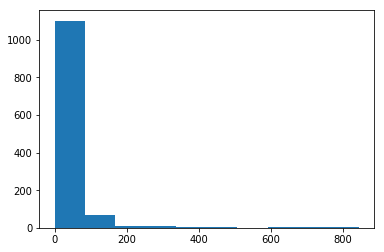

In [74]:
import numpy as np
import matplotlib.pyplot as plt
#plt.hist(numpy.log(c))
plt.hist(c)
plt.show()


In [75]:
import numpy
print("mean: "+str(numpy.mean(c))+", median: "+str(numpy.median(c))+ ", max: "+str(max(c))+", min: "+str(min(c))+".")


mean: 28.1327587935, median: 5.85012616485, max: 844.907, min: 0.09.


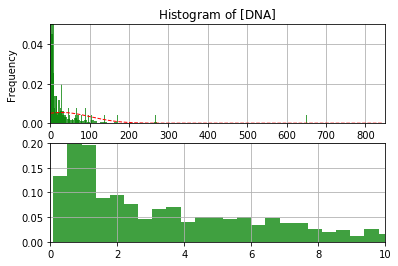

In [76]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# the histogram of the data
plt.subplot(211)
n, bins, patches = plt.hist(c, 2000, normed=1, facecolor='green', alpha=0.75)
p = plt.hist(c, 100, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
mu = numpy.mean(c)
sigma = numpy.std(c)
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('DNA Concentration')
plt.ylabel('Frequency')
plt.title(r'$\mathrm{Histogram\ of\ [DNA]}$')
plt.axis([0, 850, 0, 0.05])
plt.grid(True)


plt.subplot(212)
p = plt.hist(c, 2000, normed=1, facecolor='green', alpha=0.75)
plt.axis([0, 10, 0, 0.2])
plt.grid(True)

plt.show(p)


# Question: How many samples have blood_fractionation_method and molecular concentration?  Can you export a table with 2 columns for these two fields?


In [77]:
q = """{
  sample(first:0,not:{blood_fractionation_method:"zzz"},with_path_to:[{type:"quantification_assay"},{type:"analyte",analyte_type:"DNA"}]) {
    blood_fractionation_method
    submitter_id
    project_id
    aliquots(first:0,with_path_to:[{type:"quantification_assay"},{type:"analyte",analyte_type:"DNA"}]) {
      analytes(first:0,analyte_type:"DNA") {
        quantification_assays(first:0) {
          molecular_concentration
        }
      }
    }
  } 
}"""



data = {'query':q}
resp = requests.post(gql, auth=auth, json=data)
jresp = json.loads(resp.text)
jresp

{u'data': {u'sample': [{u'aliquots': [{u'analytes': [{u'quantification_assays': [{u'molecular_concentration': 14.6}]}]},
     {u'analytes': [{u'quantification_assays': [{u'molecular_concentration': 14.6}]}]},
     {u'analytes': [{u'quantification_assays': [{u'molecular_concentration': 14.6}]}]}],
    u'blood_fractionation_method': u'USC_HD-SCA_Protocol',
    u'project_id': u'bpa-USC_OPT1_T1',
    u'submitter_id': u'09A3B'},
   {u'aliquots': [{u'analytes': [{u'quantification_assays': [{u'molecular_concentration': 0.408}]}]}],
    u'blood_fractionation_method': u'USC_HD-SCA_Protocol',
    u'project_id': u'bpa-USC_OPT1_T1',
    u'submitter_id': u'09AAF'},
   {u'aliquots': [{u'analytes': [{u'quantification_assays': [{u'molecular_concentration': 15.6}]}]},
     {u'analytes': [{u'quantification_assays': [{u'molecular_concentration': 15.6}]}]}],
    u'blood_fractionation_method': u'USC_HD-SCA_Protocol',
    u'project_id': u'bpa-USC_OPT1_T1',
    u'submitter_id': u'09929'},
   {u'aliquots': [{

In [78]:
mc = []
for i in jresp["data"]["sample"]:
    subid = i["submitter_id"]
    projid = i["project_id"]
    bfm = i["blood_fractionation_method"]
    dnac = []
    for j in i["aliquots"]:
        for k in j["analytes"]:
            for l in k["quantification_assays"]:
                dnac.append(l["molecular_concentration"])
    line = str(subid)+"\t"+str(projid)+"\t"+str(bfm)+"\t"+str(dnac)
    print line
    mcs = [subid,projid,bfm,dnac]
    mc.append(mcs)    

09A3B	bpa-USC_OPT1_T1	USC_HD-SCA_Protocol	[14.6, 14.6, 14.6]
09AAF	bpa-USC_OPT1_T1	USC_HD-SCA_Protocol	[0.408]
09929	bpa-USC_OPT1_T1	USC_HD-SCA_Protocol	[15.6, 15.6]
09901	bpa-USC_OPT1_T1	USC_HD-SCA_Protocol	[0.305]
09969	bpa-USC_OPT1_T1	USC_HD-SCA_Protocol	[0.764]
09968	bpa-USC_OPT1_T1	USC_HD-SCA_Protocol	[0.16]
09963	bpa-USC_OPT1_T1	USC_HD-SCA_Protocol	[0.189]
09BB7	bpa-USC_OPT1_T1	USC_HD-SCA_Protocol	[0.223]
09C02	bpa-USC_OPT1_T1	USC_HD-SCA_Protocol	[0.532]
09CE4	bpa-USC_OPT1_T1	USC_HD-SCA_Protocol	[0.436, 0.436]
09BDA	bpa-USC_OPT1_T1	USC_HD-SCA_Protocol	[0.299]
09C81	bpa-USC_OPT1_T1	USC_HD-SCA_Protocol	[0.238]
09D5F	bpa-USC_OPT1_T1	USC_HD-SCA_Protocol	[17.3]
09B30	bpa-USC_OPT1_T1	USC_HD-SCA_Protocol	[0.3]
09D25	bpa-USC_OPT1_T1	USC_HD-SCA_Protocol	[0.852, 0.852]
09D41	bpa-USC_OPT1_T1	USC_HD-SCA_Protocol	[0.936, 0.936]
09D42	bpa-USC_OPT1_T1	USC_HD-SCA_Protocol	[1.03, 1.03]
09C99	bpa-USC_OPT1_T1	USC_HD-SCA_Protocol	[0.296]
09C98	bpa-USC_OPT1_T1	USC_HD-SCA_Protocol	[0.512]
09C75	bpa-US

In [79]:
print "There are "+str(len(mc))+" samples with 'blood_fractionation_method' and 'molecular concentration'."

There are 138 samples with 'blood_fractionation_method' and 'molecular concentration'.


In [86]:
import pandas as pd
m = pd.DataFrame(data=mc)
m.columns = ['Sample ID', 'Project ID', 'Blood Fractionation Method', 'Molecular Concentration']
m

,Sample ID,Project ID,Blood Fractionation Method,Molecular Concentration
0,09A3B,bpa-USC_OPT1_T1,USC_HD-SCA_Protocol,"[14.6, 14.6, 14.6]"
1,09AAF,bpa-USC_OPT1_T1,USC_HD-SCA_Protocol,[0.408]
2,09929,bpa-USC_OPT1_T1,USC_HD-SCA_Protocol,"[15.6, 15.6]"
3,09901,bpa-USC_OPT1_T1,USC_HD-SCA_Protocol,[0.305]
4,09969,bpa-USC_OPT1_T1,USC_HD-SCA_Protocol,[0.764]
5,09968,bpa-USC_OPT1_T1,USC_HD-SCA_Protocol,[0.16]
6,09963,bpa-USC_OPT1_T1,USC_HD-SCA_Protocol,[0.189]
7,09BB7,bpa-USC_OPT1_T1,USC_HD-SCA_Protocol,[0.223]
8,09C02,bpa-USC_OPT1_T1,USC_HD-SCA_Protocol,[0.532]
9,09CE4,bpa-USC_OPT1_T1,USC_HD-SCA_Protocol,"[0.436, 0.436]"
